In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
from PIL import Image
from pathlib import Path
import os

import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
from torch import nn

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

from tqdm.auto import tqdm

from timeit import default_timer as timer

os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data

In [33]:
data_dir = Path("drive/MyDrive/data")

In [34]:
def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        filenames = [f for f in filenames if not f[0] == '.']
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [35]:
walk_through_dir(data_dir)

There are 2 directories and 0 images in 'drive/MyDrive/data'.
There are 2 directories and 0 images in 'drive/MyDrive/data/test'.
There are 0 directories and 20 images in 'drive/MyDrive/data/test/magpie'.
There are 0 directories and 20 images in 'drive/MyDrive/data/test/duck'.
There are 2 directories and 0 images in 'drive/MyDrive/data/train'.
There are 0 directories and 80 images in 'drive/MyDrive/data/train/magpie'.
There are 0 directories and 80 images in 'drive/MyDrive/data/train/duck'.


In [36]:
train_dir = Path(data_dir/"train")
test_dir = Path(data_dir/"test")

train_dir, test_dir

(PosixPath('drive/MyDrive/data/train'), PosixPath('drive/MyDrive/data/test'))

### Visualizing the images

Random image path: drive/MyDrive/data/train/duck/duck_046.jpg


(-0.5, 1023.5, 575.5, -0.5)

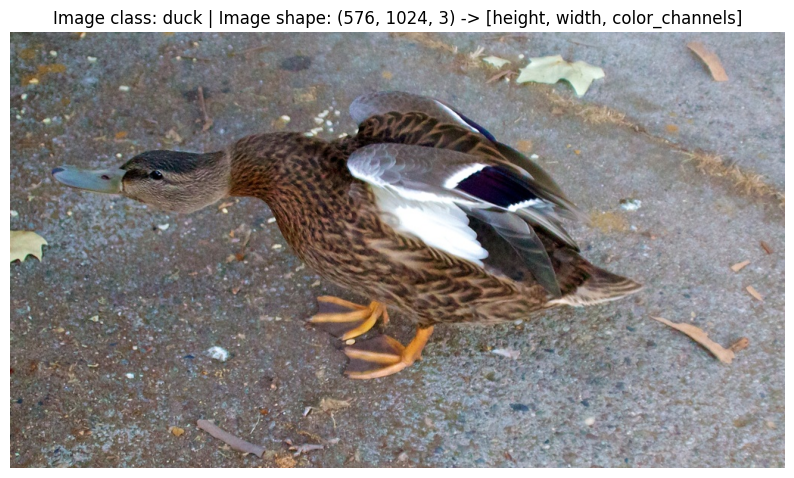

In [37]:
# set seed
random.seed(69)

# 1. get all image paths
image_path_list = list(data_dir.glob("*/*/*.jpg"))

# 2. pick a random image path
random_image_path = random.choice(image_path_list)

# 3. get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. open image
img = Image.open(random_image_path)

# 5. print metadata
print(f"Random image path: {random_image_path}")

# turn the image into an array
img_as_array = np.asarray(img)

# plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

### Data Transformation and Augmentation

In [38]:
data_transform = transforms.Compose([
    # resize our images to 224x224
    transforms.Resize(size=(224,224)),

    # turn the image into a torch.Tensor
    transforms.ToTensor(),

    # Normalize the image (VGG models expect normalized input)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

data_transform_augmented = transforms.Compose([
    # resize our images to 224x224
    transforms.Resize(size=(224,224)),

    # Data augmentation techniques
    transforms.RandomHorizontalFlip(p=0.5), # Randomly flip horizontally
    transforms.RandomRotation(degrees=15), # Random rotation within 15 degrees
    transforms.ColorJitter(brightness=0.2, # Random brightness adjustment
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),
    transforms.RandomResizedCrop(size=(224, 224), # Random crop to introduce variety
                                 scale=(0.8, 1.0),
                                 ratio=(0.9, 1.1)),

    # turn the image into a torch.Tensor
    transforms.ToTensor(),

    # Normalize the image (VGG models expect normalized input)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [39]:
data_transform(img).shape

torch.Size([3, 224, 224])

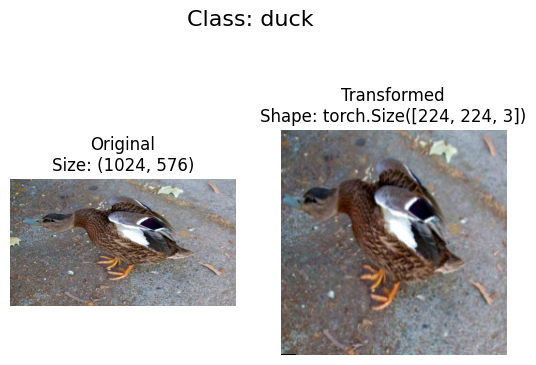

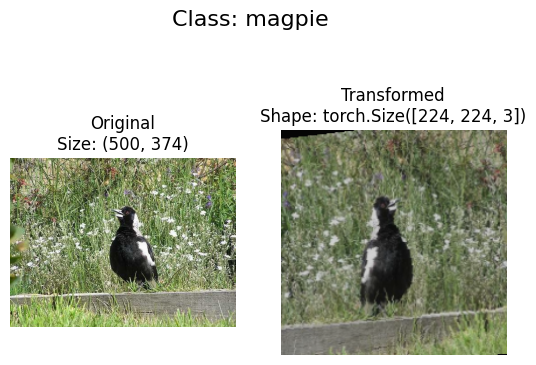

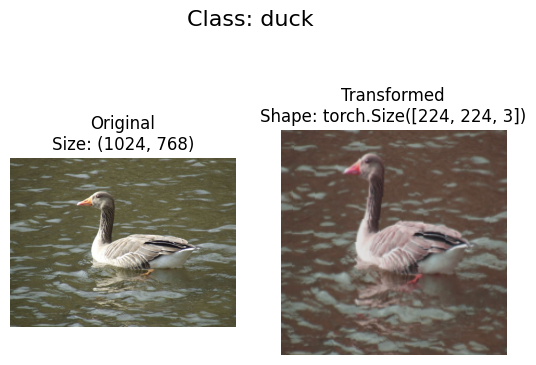

In [40]:
def plot_transformed_images(image_paths:list, transform, n=3, seed=None):
    """
    Selects random images from a path of images and loads/transforms
    them then plots the original vs the transformed version.
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image=transform(f)
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)  # reshape for broadcasting
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            transformed_image = transformed_image*std + mean
            transformed_image = transformed_image.permute(1,2,0) # note: we will need to change shape for matplotlib (C,H,W)->(H,W,C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform_augmented,
                        n=3,
                        seed=69)

### Loading Image Data

In [41]:
train_data = datasets.ImageFolder(data_dir/"train",
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(data_dir/"test",
                                  transform=data_transform)

train_data_augmented = datasets.ImageFolder(data_dir/"train",
                                            transform=data_transform_augmented,
                                            target_transform=None)
test_data_augmented = datasets.ImageFolder(data_dir/"test",
                                           transform=data_transform_augmented)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 160
    Root location: drive/MyDrive/data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 40
    Root location: drive/MyDrive/data/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [42]:
# Get class names as a list
class_names = train_data.classes
class_names

['duck', 'magpie']

In [43]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'duck': 0, 'magpie': 1}

In [44]:
# Check the lengths
len(train_data), len(test_data)

(160, 40)

In [45]:
32# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=64,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=64,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=64,
                                        num_workers=os.cpu_count(),
                                        shuffle=True)

test_dataloader_augmented = DataLoader(dataset=test_data_augmented,
                                       batch_size=64,
                                       num_workers=os.cpu_count(),
                                       shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c7cb0642170>,
 <torch.utils.data.dataloader.DataLoader at 0x7c7cb06429b0>)

In [46]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([64, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([64])


## Models

In [47]:
class VGG_1_block(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.block_1 = nn.Sequential(
            # (1,3,224,224) -> (1,64,224,224)
            nn.Conv2d(in_channels=3,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),

            # (1,64,224,224) -> (1,64,224,224)
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),

            # (1,64,224,224) -> (1,64,112,112)
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(112*112*64, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, 2))

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model_vgg_1_block = VGG_1_block().to(device)

In [48]:
class VGG_3_block(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.block_1 = nn.Sequential(
            # (1,3,224,224) -> (1,64,224,224)
            nn.Conv2d(in_channels=3,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),

            # (1,64,224,224) -> (1,64,224,224)
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),

            # (1,64,224,224) -> (1,64,112,112)
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.block_2 = nn.Sequential(

            # (1,64,112,112) -> (1,128,112,112)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),

            nn.ReLU(),

            # (1,128,112,112) -> (1,128,112,112)
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),

            nn.ReLU(),

            # (1,128,112,112) -> (1,128,56,56)
            nn.MaxPool2d(kernel_size = 2,
                         stride = 2))

        self.block_3 = nn.Sequential(
            # (1,128,56,56) -> (1,256,56,56)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),

            nn.ReLU(),

            # (1,256,56,56) -> (1,256,56,56)
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),

            nn.ReLU(),

            # (1,256,56,56) -> (1,256,56, 56)
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),

            nn.ReLU(),

            # (1,256,56,56) -> (1,256,28,28)
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(28*28*256, 4096),
            nn.ReLU())

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())

        self.fc2= nn.Sequential(
            nn.Linear(4096,2))

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model_vgg_3_block = VGG_3_block().to(device)
model_vgg_3_block_augmentation = VGG_3_block().to(device)

In [49]:
class VGG16TransferLearning(nn.Module):
    def __init__(self, tune_all_layers=False):
        super(VGG16TransferLearning, self).__init__()

        # Load pretrained VGG16
        self.vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

        # Modify the classifier (final MLP layers)
        self.vgg16.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 2)
        )

        # Freeze/Unfreeze layers based on strategy
        self.tune_all_layers = tune_all_layers
        self._freeze_layers()

    def _freeze_layers(self):
        if not self.tune_all_layers:
            # Freeze all convolutional layers
            for param in self.vgg16.features.parameters():
                param.requires_grad = False
        else:
            # Unfreeze all layers
            for param in self.vgg16.parameters():
                param.requires_grad = True

    def forward(self, x):
        return self.vgg16(x)

# Create model with all layers trainable
model_vgg_16_all_layers = VGG16TransferLearning(tune_all_layers=True).to(device)

# Create model with only mlp layers trainable
model_vgg_16_mlp_layers = VGG16TransferLearning(tune_all_layers=False).to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 233MB/s]


In [50]:
class DeepMLP(nn.Module):
    """
    Deeper architecture with more layers but fewer neurons per layer
    """
    def __init__(self):
        super(DeepMLP, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(150528, 2048),
            nn.ReLU(inplace=True),

            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),

            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.network(x)

class WideMLP(nn.Module):
    """
    Wider architecture with fewer layers but more neurons per layer
    """
    def __init__(self):
        super(WideMLP, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(150528, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),

            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.network(x)

class BalancedMLP(nn.Module):
    """
    Balanced architecture (similar to original)
    """
    def __init__(self):
        super(BalancedMLP, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(150528, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.network(x)

# Initialize models
model_deep_mlp = DeepMLP().to(device)
model_wide_mlp = WideMLP().to(device)
model_balanced_mlp = BalancedMLP().to(device)

# Print parameter counts
models = {
    'Deep MLP': model_deep_mlp,
    'Wide MLP': model_wide_mlp,
    'Balanced MLP': model_balanced_mlp
}

for name, model in models.items():
    params = sum(p.numel() for p in model.parameters())
    print(f"{name}:")
    print(f"Total parameters: {params}")
    print('-' * 50)

Deep MLP:
Total parameters: 312448898
--------------------------------------------------
Wide MLP:
Total parameters: 626007554
--------------------------------------------------
Balanced MLP:
Total parameters: 156110594
--------------------------------------------------


### Train and Test

In [51]:
# Denormalization constants
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               writer: SummaryWriter,
               global_step: int):
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader): # 0, 1, 2
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        batch_acc = (y_pred_class == y).sum().item()/len(y_pred)

        # Log metrics per iteration
        writer.add_scalar('Loss/train_iteration', loss.item(), global_step + batch)
        writer.add_scalar('Accuracy/train_iteration', batch_acc, global_step + batch)

        train_loss += loss.item()
        train_acc += batch_acc
    # train_iteration = 2
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc, global_step + len(dataloader) # 0->3

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              writer: SummaryWriter,
              global_step: int):
    model.eval()
    test_loss, test_acc = 0, 0

    # Store images and predictions for visualization
    all_images = []
    all_preds = []
    all_labels = []

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader): # 0
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)

            test_pred_labels = test_pred_logits.argmax(dim=1)
            batch_acc = (test_pred_labels == y).sum().item()/len(test_pred_labels)

            # Log test accuracy per iteration
            writer.add_scalar('Accuracy/test_iteration', batch_acc, global_step + batch - 3)

            test_loss += loss.item()
            test_acc += batch_acc

            # Store images and predictions
            all_images.append(X.cpu())
            all_preds.append(test_pred_labels.cpu())
            all_labels.append(y.cpu())

    # Log test images with predictions
    images = torch.cat(all_images)
    preds = torch.cat(all_preds)
    labels = torch.cat(all_labels)

    # Create a grid of images with predictions
    num_images = len(images)
    figure = plt.figure(figsize=(16, 16))
    for idx in range(num_images):
        plt.subplot(8, 5, idx + 1)
        plt.axis('off')
        plt.imshow((images[idx]*std+mean).permute(1, 2, 0))
        color = 'green' if preds[idx] == labels[idx] else 'red'
        plt.title(f'Pred: {preds[idx].item()}\nTrue: {labels[idx].item()}', color=color)

    writer.add_figure('Test Predictions', figure, global_step)
    plt.close()

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          model_name: str = "model"):

    # Initialize TensorBoard writer
    writer = SummaryWriter(f'drive/MyDrive/runs/{model_name}')

    results = {}

    global_step = 1

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, global_step = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            writer=writer,
            global_step=global_step
        )

        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            writer=writer,
            global_step=global_step
        )

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        if epoch == epochs-1:
            results["train_loss"]=(train_loss)
            results["train_acc"]=(train_acc)
            results["test_loss"]=(test_loss)
            results["test_acc"]=(test_acc)

    writer.close()
    return results

In [52]:
models = {
    "model_vgg_1_block": model_vgg_1_block,
    "model_vgg_3_block": model_vgg_3_block,
    "model_vgg_3_block_augmentation": model_vgg_3_block_augmentation,
    "model_vgg_16_all_layers": model_vgg_16_all_layers,
    "model_vgg_16_mlp_layers": model_vgg_16_mlp_layers,
    "model_deep_mlp": model_deep_mlp,
    "model_wide_mlp": model_wide_mlp,
    "model_balanced_mlp": model_balanced_mlp
}
model_results = {}
for model_name, model in models.items():
    print("Training", model_name)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
    start_time = timer()

    if model_name == "model_vgg_3_block_augmentation":
        model_results[model_name] = train(
            model=model,
            train_dataloader=train_dataloader_augmented,
            test_dataloader=test_dataloader_augmented,
            optimizer=optimizer,
            loss_fn=nn.CrossEntropyLoss(),
            epochs=5,
            model_name=model_name
        )
    else:
        model_results[model_name] = train(
            model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fn=nn.CrossEntropyLoss(),
            epochs=5,
            model_name=model_name
        )

    end_time = timer()
    model_results[model_name]["train_time"] = end_time-start_time
    model_results[model_name]["num_params"] = sum(p.numel() for p in model_vgg_16_mlp_layers.parameters() if p.requires_grad)
    print("="*25)

Training model_vgg_1_block


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 299.8353 | train_acc: 0.5208 | test_loss: 247.5726 | test_acc: 0.5000
Epoch: 2 | train_loss: 103.7574 | train_acc: 0.5052 | test_loss: 0.7246 | test_acc: 0.5000
Epoch: 3 | train_loss: 0.7097 | train_acc: 0.5156 | test_loss: 0.6818 | test_acc: 0.5000
Epoch: 4 | train_loss: 0.6811 | train_acc: 0.5052 | test_loss: 0.6915 | test_acc: 0.5000
Epoch: 5 | train_loss: 0.6901 | train_acc: 0.5312 | test_loss: 0.6932 | test_acc: 0.5000
Training model_vgg_3_block


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.0813 | train_acc: 0.5469 | test_loss: 0.8749 | test_acc: 0.5000
Epoch: 2 | train_loss: 0.7470 | train_acc: 0.5365 | test_loss: 0.6895 | test_acc: 0.5500
Epoch: 3 | train_loss: 0.7083 | train_acc: 0.4323 | test_loss: 0.6930 | test_acc: 0.5000
Epoch: 4 | train_loss: 0.6936 | train_acc: 0.5000 | test_loss: 0.6934 | test_acc: 0.5000
Epoch: 5 | train_loss: 0.6927 | train_acc: 0.5156 | test_loss: 0.6934 | test_acc: 0.5000
Training model_vgg_3_block_augmentation


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.0488 | train_acc: 0.5104 | test_loss: 1.1177 | test_acc: 0.5000
Epoch: 2 | train_loss: 0.8131 | train_acc: 0.5625 | test_loss: 0.9451 | test_acc: 0.5000
Epoch: 3 | train_loss: 3.2236 | train_acc: 0.4948 | test_loss: 0.6926 | test_acc: 0.5000
Epoch: 4 | train_loss: 0.6981 | train_acc: 0.4635 | test_loss: 0.6935 | test_acc: 0.5000
Epoch: 5 | train_loss: 0.6925 | train_acc: 0.5469 | test_loss: 0.6932 | test_acc: 0.5000
Training model_vgg_16_all_layers


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 6.8011 | train_acc: 0.4375 | test_loss: 0.6999 | test_acc: 0.5000
Epoch: 2 | train_loss: 0.6995 | train_acc: 0.5052 | test_loss: 0.9473 | test_acc: 0.5000
Epoch: 3 | train_loss: 1.1306 | train_acc: 0.5156 | test_loss: 0.9540 | test_acc: 0.5000
Epoch: 4 | train_loss: 0.7820 | train_acc: 0.5052 | test_loss: 0.6932 | test_acc: 0.5000
Epoch: 5 | train_loss: 0.6930 | train_acc: 0.5104 | test_loss: 0.6927 | test_acc: 0.5000
Training model_vgg_16_mlp_layers


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 25.1178 | train_acc: 0.5625 | test_loss: 33.9618 | test_acc: 0.5000
Epoch: 2 | train_loss: 12.1361 | train_acc: 0.7188 | test_loss: 3.7016 | test_acc: 0.5250
Epoch: 3 | train_loss: 2.4457 | train_acc: 0.7292 | test_loss: 0.0811 | test_acc: 0.9750
Epoch: 4 | train_loss: 0.1435 | train_acc: 0.9583 | test_loss: 0.3534 | test_acc: 0.9250
Epoch: 5 | train_loss: 0.0812 | train_acc: 0.9792 | test_loss: 0.2552 | test_acc: 0.9500
Training model_deep_mlp


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1722 | train_acc: 0.4688 | test_loss: 0.6726 | test_acc: 0.6250
Epoch: 2 | train_loss: 0.6790 | train_acc: 0.6354 | test_loss: 0.7855 | test_acc: 0.5000
Epoch: 3 | train_loss: 0.6973 | train_acc: 0.5573 | test_loss: 0.6524 | test_acc: 0.6750
Epoch: 4 | train_loss: 0.5630 | train_acc: 0.7344 | test_loss: 0.9291 | test_acc: 0.6750
Epoch: 5 | train_loss: 0.6198 | train_acc: 0.7240 | test_loss: 0.7171 | test_acc: 0.6000
Training model_wide_mlp


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 109.7015 | train_acc: 0.4688 | test_loss: 62.7836 | test_acc: 0.5000
Epoch: 2 | train_loss: 27.8378 | train_acc: 0.5156 | test_loss: 0.9823 | test_acc: 0.5000
Epoch: 3 | train_loss: 1.4968 | train_acc: 0.6354 | test_loss: 1.1253 | test_acc: 0.6500
Epoch: 4 | train_loss: 1.2857 | train_acc: 0.6771 | test_loss: 2.3568 | test_acc: 0.5750
Epoch: 5 | train_loss: 1.9668 | train_acc: 0.6146 | test_loss: 1.9926 | test_acc: 0.6500
Training model_balanced_mlp


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.5035 | train_acc: 0.4948 | test_loss: 0.6545 | test_acc: 0.6250
Epoch: 2 | train_loss: 1.0206 | train_acc: 0.6094 | test_loss: 1.9620 | test_acc: 0.5250
Epoch: 3 | train_loss: 1.1039 | train_acc: 0.5833 | test_loss: 0.7609 | test_acc: 0.6000
Epoch: 4 | train_loss: 0.5233 | train_acc: 0.7656 | test_loss: 0.8355 | test_acc: 0.6500
Epoch: 5 | train_loss: 0.6203 | train_acc: 0.7656 | test_loss: 0.8254 | test_acc: 0.6000


In [54]:
def save_model_to_drive(model, model_name):
  """Saves a PyTorch model to Google Drive."""
  model_path = f"/content/drive/MyDrive/saved_models/{model_name}.pth"
  torch.save(model.state_dict(), model_path)
  print(f"Model '{model_name}' saved to {model_path}")

for model_name, model in models.items():
  save_model_to_drive(model, model_name)

Model 'model_vgg_1_block' saved to /content/drive/MyDrive/saved_models/model_vgg_1_block.pth
Model 'model_vgg_3_block' saved to /content/drive/MyDrive/saved_models/model_vgg_3_block.pth
Model 'model_vgg_3_block_augmentation' saved to /content/drive/MyDrive/saved_models/model_vgg_3_block_augmentation.pth
Model 'model_vgg_16_all_layers' saved to /content/drive/MyDrive/saved_models/model_vgg_16_all_layers.pth
Model 'model_vgg_16_mlp_layers' saved to /content/drive/MyDrive/saved_models/model_vgg_16_mlp_layers.pth
Model 'model_deep_mlp' saved to /content/drive/MyDrive/saved_models/model_deep_mlp.pth
Model 'model_wide_mlp' saved to /content/drive/MyDrive/saved_models/model_wide_mlp.pth
Model 'model_balanced_mlp' saved to /content/drive/MyDrive/saved_models/model_balanced_mlp.pth


In [55]:
# save model_results to dictionary

import pickle

with open('/content/drive/My Drive/model_results.pkl', 'wb') as f:
  pickle.dump(model_results, f)

In [56]:
df_model_results = pd.DataFrame.from_dict(model_results)
df_model_results

model_vgg_1_block  model_vgg_3_block  \
train_loss       6.900939e-01       6.927499e-01   
train_acc        5.312500e-01       5.156250e-01   
test_loss        6.932472e-01       6.933735e-01   
test_acc         5.000000e-01       5.000000e-01   
train_time       8.448993e+02       6.993119e+02   
num_params       1.195540e+08       1.195540e+08   

            model_vgg_3_block_augmentation  model_vgg_16_all_layers  \
train_loss                    6.924777e-01             6.930378e-01   
train_acc                     5.468750e-01             5.104167e-01   
test_loss                     6.931667e-01             6.926578e-01   
test_acc                      5.000000e-01             5.000000e-01   
train_time                    7.792629e+02             7.292446e+02   
num_params                    1.195540e+08             1.195540e+08   

            model_vgg_16_mlp_layers  model_deep_mlp  model_wide_mlp  \
train_loss             8.116966e-02    6.198364e-01    1.966789e+00   
train_acc              9.791667e-01    7.239583e-01    6.145833e-01   
test_loss              2.551700e-01    7.170737e-01    1.992613e+00   
test_acc               9.500000e-01    6.000000e-01    6.500000e-01   
train_time             6.895696e+02    7.081328e+02    7.905308e+02   
num_params             1.195540e+08    1.195540e+08    1.195540e+08   

            model_balanced_mlp  
train_loss        6.203354e-01  
train_acc         7.656250e-01  
test_loss         8.253797e-01  
test_acc          6.000000e-01  
train_time        7.681486e+02  
num_params        1.195540e+08

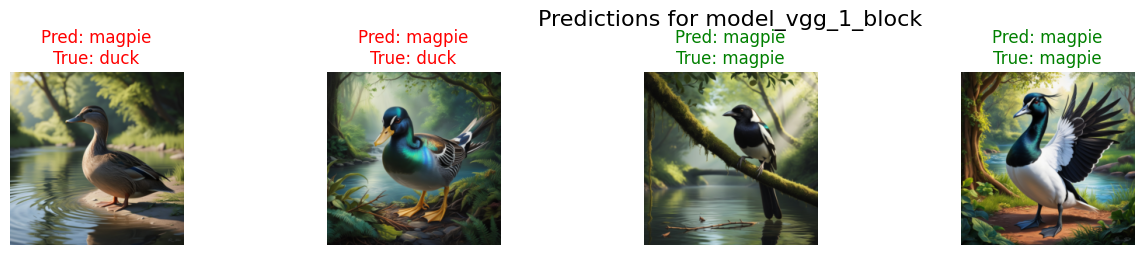

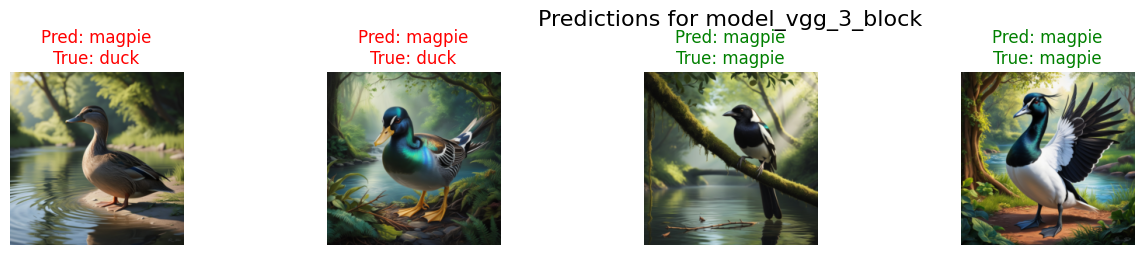

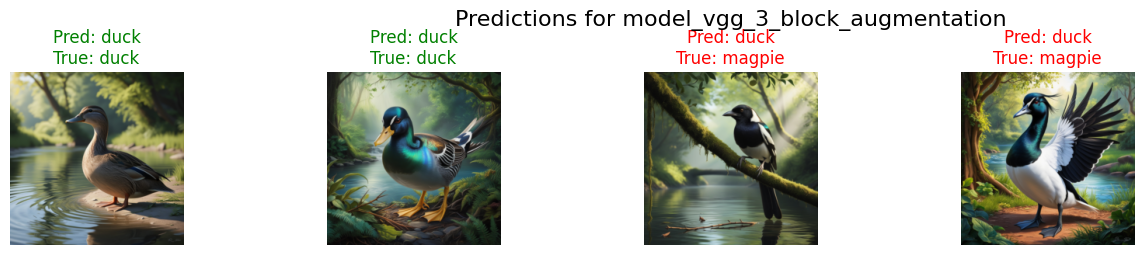

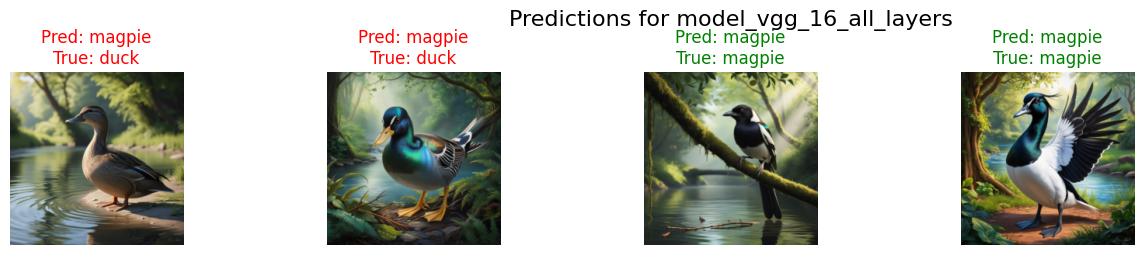

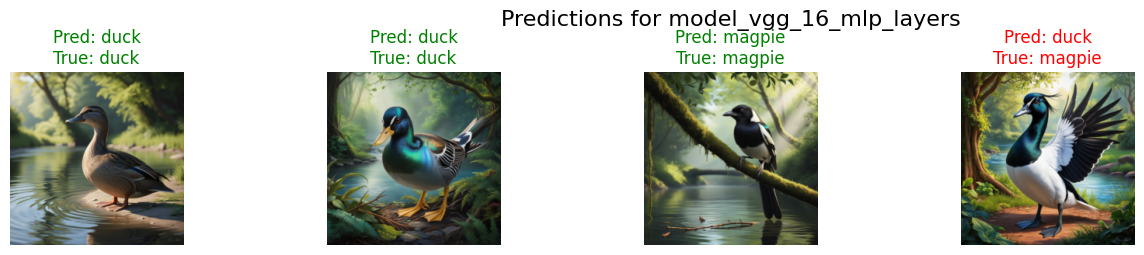

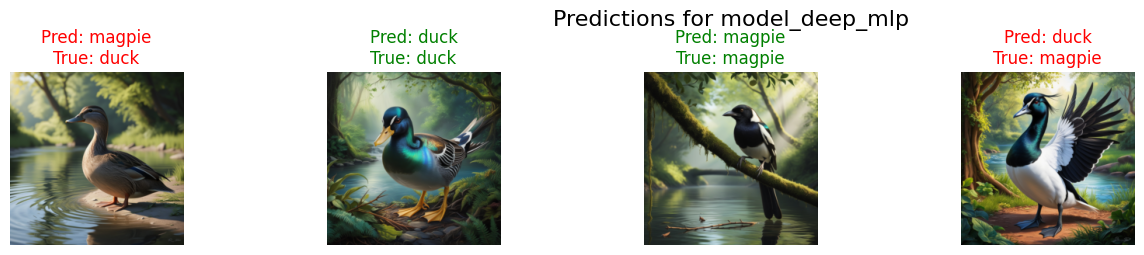

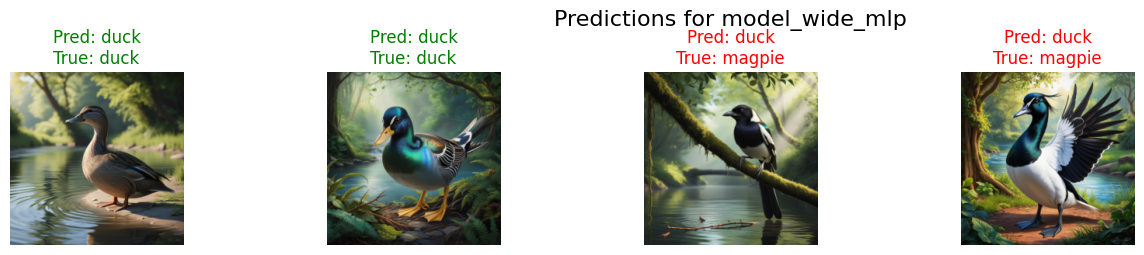

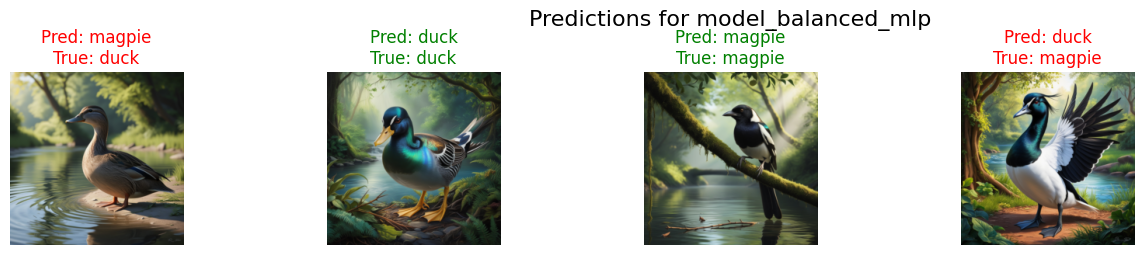

In [64]:
# prompt: given this:
data_dir = Path("/content/drive/MyDrive/test_data")
# Assuming your models are loaded and named as in your provided code
# Data Transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_data = datasets.ImageFolder(data_dir / "test", transform=data_transform)
test_dataloader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Get the prediction and Create a plot that shows the prediction and actual label with images for all models.

def get_predictions_and_plot(models, test_dataloader, device, class_names=None):
  """Gets predictions for all models and creates a plot with images, predictions, and actual labels."""

  for model_name, model in models.items():
    model.eval()  # Set the model to evaluation mode
    all_images = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
      for batch_idx, (images, labels) in enumerate(test_dataloader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_images.append(images.cpu())
        all_preds.append(predicted.cpu())
        all_labels.append(labels.cpu())

    # Concatenate predictions and labels from all batches
    all_images = torch.cat(all_images)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Create a plot
    num_images = len(all_images)
    figure = plt.figure(figsize=(16, 16))
    plt.suptitle(f"Predictions for {model_name}", fontsize=16)

    for idx in range(num_images):
      plt.subplot(8, 5, idx + 1)
      plt.axis('off')
      plt.imshow((all_images[idx] * std + mean).permute(1, 2, 0))

      # Get predicted and true class names if available
      predicted_class = int(all_preds[idx].item())
      true_class = int(all_labels[idx].item())
      predicted_class_name = class_names[predicted_class] if class_names else predicted_class
      true_class_name = class_names[true_class] if class_names else true_class

      color = 'green' if predicted_class == true_class else 'red'
      plt.title(f'Pred: {predicted_class_name}\nTrue: {true_class_name}', color=color)


    plt.tight_layout()
    plt.show()


# Assuming you have the class names (e.g., ['class1', 'class2'])
class_names = ['duck', 'magpie']

# Call the function with your models and dataloader
get_predictions_and_plot(models, test_dataloader, device, class_names)  # Replace with your models, test_dataloader, and device